In [1]:
import json
import os
from dotenv import load_dotenv
from pinecone import Pinecone
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from typing import List, Callable, Optional, Iterable
from abc import ABC, abstractmethod
import logging
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

/home/codespace/.python/current/lib/python3.10/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
transformer_json = pd.read_json("transformer.json")

# Prepare data

Min length: 0
Max length: 33372
Mean length: 8536.148423005567


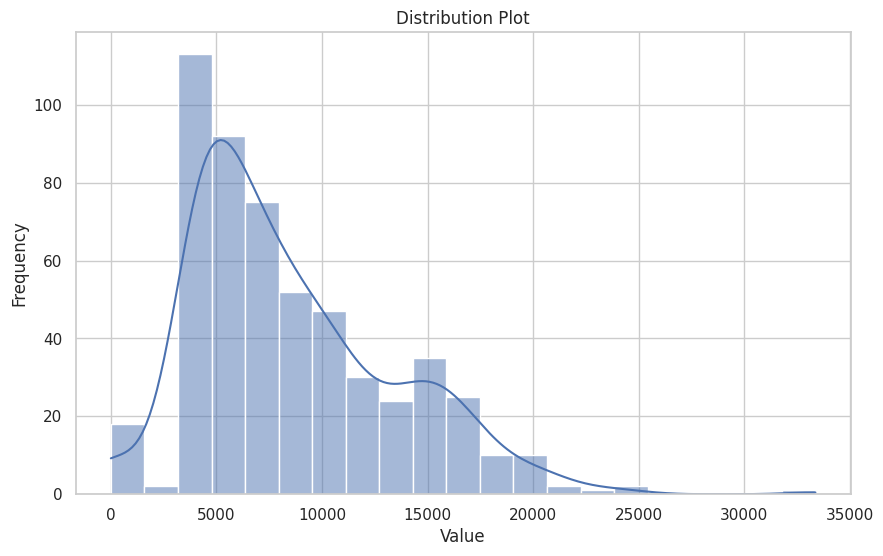

In [3]:
# check the data
list_text = []

for text in transformer_json["train"]["text"]:
    list_text.append(len(text))


print(f"Min length: {min(list_text)}")
print(f"Max length: {max(list_text)}")
print(f"Mean length: {sum(list_text) / len(list_text)}")

# Create the distribution plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(list_text, kde=True)

# Customize the plot
plt.title('Distribution Plot')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

## remove len(text) == 0 and split text into chunks

In [4]:
logger = logging.getLogger(__name__)

class BaseDocumentTransformer:
    # Dummy base class to match the structure
    pass

class TextSplitter(BaseDocumentTransformer, ABC):
    """Interface for splitting text into chunks."""

    def __init__(
        self,
        chunk_size: int = 4000,
        chunk_overlap: int = 200,
        length_function: Callable[[str], int] = len,
        keep_separator: bool = False,
        add_start_index: bool = False,
        strip_whitespace: bool = True,
    ) -> None:
        """Create a new TextSplitter.
        Args:
            chunk_size: Maximum size of chunks to return
            chunk_overlap: Overlap in characters between chunks
            length_function: Function that measures the length of given chunks
            keep_separator: Whether to keep the separator in the chunks
            add_start_index: If True, includes chunk's start index in metadata
            strip_whitespace: If True, strips whitespace from the start and end of
                              every document
        """
        if chunk_overlap > chunk_size:
            raise ValueError(
                f"Got a larger chunk overlap ({chunk_overlap}) than chunk size "
                f"({chunk_size}), should be smaller."
            )
        self._chunk_size = chunk_size
        self._chunk_overlap = chunk_overlap
        self._length_function = length_function
        self._keep_separator = keep_separator
        self._add_start_index = add_start_index
        self._strip_whitespace = strip_whitespace

    @abstractmethod
    def split_text(self, text: str) -> List[str]:
        """Split text into multiple components."""
        pass

    def _join_docs(self, docs: List[str], separator: str) -> Optional[str]:
        text = separator.join(docs)
        if self._strip_whitespace:
            text = text.strip()
        if text == "":
            return None
        else:
            return text
    
    def _merge_splits(self, splits: Iterable[str], separator: str) -> List[str]:
        # We now want to combine these smaller pieces into medium size
        # chunks to send to the LLM.
        separator_len = self._length_function(separator)
        docs = []
        current_doc: List[str] = []
        total = 0

        for d in splits:
            _len = self._length_function(d)
            if (
                total + _len + (separator_len if len(current_doc) > 0 else 0)
                > self._chunk_size
            ):
                if total > self._chunk_size:
                    logger.warning(
                        f"Created a chunk of size {total}, "
                        f"which is longer than the specified {self._chunk_size}"
                    )
                if len(current_doc) > 0:
                    doc = self._join_docs(current_doc, separator)
                    if doc is not None:
                        docs.append(doc)
                # Keep on popping if:
                # - we have a larger chunk than in the chunk overlap
                # - or if we still have any chunks and the length is long
                while total > self._chunk_overlap or (
                    total + _len + (separator_len if len(current_doc) > 0 else 0)
                    > self._chunk_size
                    and total > 0
                ):
                    total -= self._length_function(current_doc[0]) + (
                        separator_len if len(current_doc) > 1 else 0
                    )
                    current_doc = current_doc[1:]

            current_doc.append(d)
            total += _len + (separator_len if len(current_doc) > 1 else 0)

        doc = self._join_docs(current_doc, separator)
        if doc is not None:
            docs.append(doc)

        return docs

class NewlineTextSplitter(TextSplitter):
    def split_text(self, text: str) -> List[str]:
        if len(text) <= self._chunk_size:
            return [text]
        lines = text.split('\n')
        splits = []
        current_chunk = ""
        for line in lines:
            if len(current_chunk) + len(line) + 1 > self._chunk_size:
                splits.append(current_chunk)
                current_chunk = line
            else:
                if current_chunk:
                    current_chunk += '\n'
                current_chunk += line
        if current_chunk:
            splits.append(current_chunk)
        return splits

# Function to concatenate information into a single document
def create_document(transformer):
    name = "Name: " + ", ".join(transformer["name"])
    category = "Category: " + ", ".join(transformer["category"])
    description = "Description: " + transformer["text"]
    related_transformers = "Related Transformers: " + ", ".join(transformer["related_transformers"])

    document = f"{name}\n{category}\n{description}\n{related_transformers}"
    return document

# Function to process JSON data
def process_json_data(data, splitter):
    processed_data = {}
    
    for name, category, text, related in zip(data["name"], data["category"], data["text"], data["related_transformers"]):
        document = create_document({
            "name": [name],
            "category": [category],
            "text": text,
            "related_transformers": [related]
        })

        if len(document) > splitter._chunk_size:
            split_texts = splitter.split_text(document)
            processed_data[name] = split_texts
        else:
            processed_data[name] = [document]

    return processed_data

# Example usage
splitter = NewlineTextSplitter(chunk_size=8192)

# Process the data
processed_data = process_json_data(transformer_json['train'], splitter)

Min length: 22
Max length: 8192
Mean length: 5666.32808716707


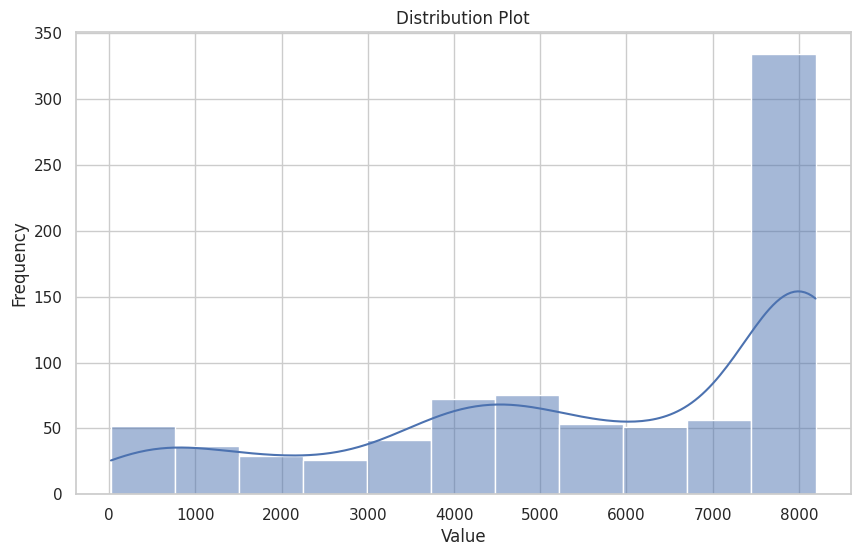

In [5]:
# check the data
list_text = []
keys = processed_data.keys()

for key in keys:
    for elements in processed_data[key]:
        list_text.append(len(elements))


print(f"Min length: {min(list_text)}")
print(f"Max length: {max(list_text)}")
print(f"Mean length: {sum(list_text) / len(list_text)}")

# Create the distribution plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(list_text, kde=True)

# Customize the plot
plt.title('Distribution Plot')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Load the model

In [6]:
model_name = "BAAI/bge-m3"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
    query_instruction = "search_query:",
    embed_instruction = "search_document:"
)

/home/codespace/.python/current/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


: 

In [7]:
embedding = hf.embed_documents(processed_data["TopologyBuilder"])
len(embedding)

# Vectore store

In [ ]:
# Load environment variables from .env file
load_dotenv()
pinecone_api_key = os.getenv("API_KEY")

# Initialize Pinecone
pc = Pinecone(api_key=pinecone_api_key)
index_name = "rag-example"

# Create the index if it doesn't exist
if index_name not in pc.list_indexes():
    pc.create_index(index_name, dimension=768)  # Adjust dimension to match the model output

# Connect to the index
index = pc.Index(index_name)

# Load the embedding model
model_name = "BAAI/bge-m3"




index.upsert(vectors=vectors)

# Save collection to a JSON file
def save_collection_to_file(vectors, file_path):
    with open(file_path, 'w') as f:
        json.dump(vectors, f)

save_collection_to_file(vectors, "collection.json")

# Load collection from a JSON file
def load_collection_from_file(file_path):
    with open(file_path, 'r') as f:
        vectors = json.load(f)
    index.upsert(vectors=vectors)

load_collection_from_file("collection.json")

# Define a simple retrieval function
def retrieve(query, k=3):
    query_embedding = embed_text([query])[0]
    results = index.query(queries=[query_embedding.tolist()], top_k=k, include_metadata=True)
    return [(match['metadata']['text'], match['score']) for match in results['matches']]

# Example usage
query = "What are transformers used for?"
results = retrieve(query)
for result in results:
    print(result)
